# Data Processing and Feature Extraction

The objective is to organize the data to be used on the model training

Overview of the process:

1. Load al Files located on the folders by artist
2. Processs Midi files (Train and Test):
    - Extract metadata from each song
        - include general information
    - Split midi file into 30-second chunks
        - Trim each chunk 
        - "Stretch" chunks that fall just short of 30 seconds 
    - Write out chunks to intermediate folders, with an iter_id for each
    - Create a DataFrame with metadata for easy access
    - Generate a Feature Vector with feature extraction
3. Load chunks into DataFrame (Train and Test)
    - Read each chunk from disk
        - Generate information tensor using mid_acess
    - Store each midi file object in a Pandas DataFrame column

In [1]:
import os
import midi_access as midi
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd

sns.set_theme(style="whitegrid")

BASE_MIDI_DIR = './dataset_module_7'  
ARTISTS_DIR = os.path.join(BASE_MIDI_DIR, 'all_files')

In [2]:
# Load all songs by artist
artist_midi_dict = midi.load_midi_files_by_artist(ARTISTS_DIR)

/Users/zacharyartman/Documents/Class/AAI511/aai511-final-project-group6/venv/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error loading ./dataset_module_7/all_files/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


## FEATURE EXTRACTION

Given the mid information, extract information related to the file

In [3]:
# FEATURE EXTRACTION FUNCTION
def generate_feature_vector(midi_data, top_chords):
    pitch_hist = midi.get_pitch_class_histogram(midi_data)
    ioi_hist = midi.get_ioi_histogram(midi_data)
    chord_hist = midi.get_chord_histogram(midi_data, top_chords)
    return np.concatenate([pitch_hist, ioi_hist, chord_hist])

## Processing chunks and saving

This will run through all the files and:
- generate chunks and save a chunks for later access and reference. 
For e

In [4]:
def process_and_save_chunks_with_features(artist, song_idx, midi_data, output_dir, top_chords):
    chunks = midi.split_midi_into_chunks(midi_data)
    chunk_features = []
    for i, chunk in enumerate(chunks):
        # Generate filename and save chunk
        chunk_filename = f"{artist}_song{song_idx}_chunk{i}.mid"
        chunk_path = os.path.join(output_dir, chunk_filename)
        chunk.write(chunk_path)
        
        # Extract features for this chunk
        feature_vector = generate_feature_vector(chunk, top_chords)
        chunk_features.append({
            'artist': artist,
            'song_idx': song_idx,
            'chunk_idx': i,
            'chunk_path': chunk_path,
            'features': feature_vector
        })
    return chunk_features



> NOTICE: this will first remove the contents of intermediate_chunks folder. 

In [5]:
import shutil

all_chunk_features = []
output_dir = os.path.join(BASE_MIDI_DIR, 'intermediate_chunks')

# Clean up the output directory if it exists
if os.path.exists(output_dir):
    print(f"Removing existing output directory: {output_dir}")  
    shutil.rmtree(output_dir)

# Create the output directory
print(f"Creating output directory: {output_dir}")
os.makedirs(output_dir, exist_ok=True)
top_chords = midi.get_top_chords(artist_midi_dict, top_n=20)

# Process each artist's MIDI files and extract features
for artist, song_list in artist_midi_dict.items():
    print(f"Processing artist: {artist} with {len(song_list)} songs")
    for idx, midi_data in enumerate(song_list):
        chunk_features = process_and_save_chunks_with_features(artist, idx, midi_data, output_dir, top_chords)
        all_chunk_features.extend(chunk_features)


df_chunks = pd.DataFrame(all_chunk_features)
print(f"Total chunks processed: {len(df_chunks)}")
print(f"Saving chunk features to: {os.path.join(output_dir, './songs_by_artist_chunk_features.csv')}")

df_chunks.to_csv(os.path.join(output_dir, './songs_by_artist_chunk_features.csv'), index=False)

df_chunks.head()

Removing existing output directory: ./dataset_module_7/intermediate_chunks
Creating output directory: ./dataset_module_7/intermediate_chunks
Processing artist: Mozart with 90 songs


/Users/zacharyartman/Documents/Class/AAI511/aai511-final-project-group6/venv/lib/python3.9/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Processing artist: Chopin with 136 songs
Processing artist: Beethoven with 132 songs
Processing artist: Bach with 122 songs
Total chunks processed: 5208
Saving chunk features to: ./dataset_module_7/intermediate_chunks/./songs_by_artist_chunk_features.csv


,artist,song_idx,chunk_idx,chunk_path,features
0,Mozart,0,0,./dataset_module_7/intermediate_chunks/Mozart_...,"[0.04538799414348463, 0.0, 0.09224011713030747..."
1,Mozart,0,1,./dataset_module_7/intermediate_chunks/Mozart_...,"[0.07196969696969698, 0.020202020202020204, 0...."
2,Mozart,0,2,./dataset_module_7/intermediate_chunks/Mozart_...,"[0.04222648752399232, 0.015355086372360844, 0...."
3,Mozart,0,3,./dataset_module_7/intermediate_chunks/Mozart_...,"[0.05084745762711865, 0.006355932203389831, 0...."
4,Mozart,0,4,./dataset_module_7/intermediate_chunks/Mozart_...,"[0.12757201646090535, 0.006172839506172839, 0...."


Present all 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5208 entries, 0 to 5207
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist      5208 non-null   object
 1   song_idx    5208 non-null   int64 
 2   chunk_idx   5208 non-null   int64 
 3   chunk_path  5208 non-null   object
 4   features    5208 non-null   object
dtypes: int64(2), object(3)
memory usage: 203.6+ KB


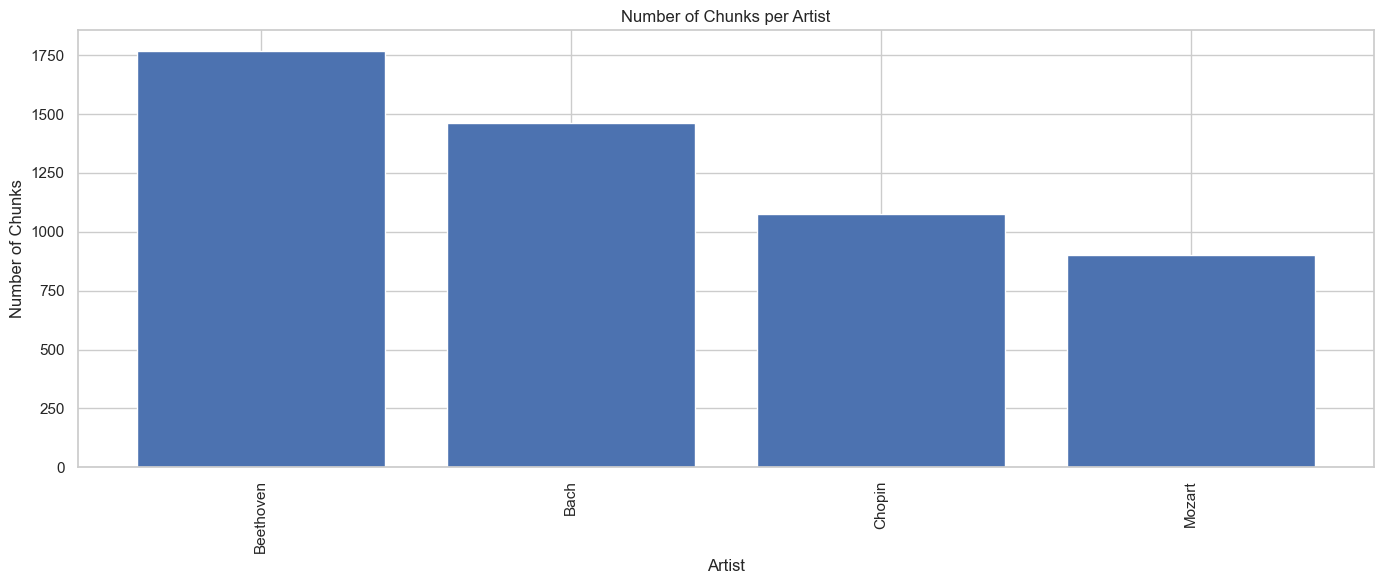

In [6]:
df_chunks.info()

chunk_counts = df_chunks['artist'].value_counts()

plt.figure(figsize=(14, 6))
plt.bar(chunk_counts.index, chunk_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Number of Chunks')
plt.title('Number of Chunks per Artist')
plt.tight_layout()
plt.show()